# Lab 10d: Does _Klebsiella oxytoca_ have free will?
This lab will familiarize students with solving linear resource allocation problems using [linear programming](https://en.wikipedia.org/wiki/Linear_programming). The example problem explored in this lab is the carbon choice problem modeled by [Kompala et al. 1986](paper/Kompala-BiotechBioengineering-1986.pdf). 
* Understanding how bacterial cells choose between different sugars, such as glucose, is a crucial area of study in biology. This decision-making process also observed in [other organisms like yeast](https://pubmed.ncbi.nlm.nih.gov/9381177/), is encoded at a molecular level using [carbon catabolite repression pathways](https://pubmed.ncbi.nlm.nih.gov/18628769/).

### Hypothesis
Suppose we hypothesize that cells are rational consumers, and they are maximizing a linear utility function subject to a budget constraint by carefully choosing which enzyme(s) $e_{i}$ (decision variables) to construct (enzymes are expensive to synthesize) subject to limited cellular resources:
\begin{eqnarray*}
\text{maximize}~U(e_{1},\dotsc,e_{n}) & = & \sum_{i\in\mathcal{S}}\gamma_{i}\cdot{e}_{i}(R) \\
\text{subject to}~\sum_{i\in\mathcal{S}}\hat{b}_{i}\cdot{e}_{i}(R) & = & 1 \\
\text{and}~e_{i}&\geq&{0}\qquad{i=1,2,\dots,n}
\end{eqnarray*}
where $\gamma_{i}$ (the unit benefit from making $e_{i}$) is defined as:
\begin{equation}
\gamma_{i} \equiv \left(\frac{\mu_{i}s_{i}c}{K_{i}+s_{i}}\right)
\end{equation}
and $\hat{b}_{i}$ (the scaled unit cost of manufacturing $e_{i}$) is approximated by:
\begin{equation}
\hat{b}_{i}^{-1} \approx \frac{1}{\delta_{i}}\cdot{\left(\frac{1}{\tau_{i}}+\lambda_{i}\right)}
\end{equation}
__Super cool__: We compute the values of $\gamma_{i}$ and $\hat{b}_{i}$ from the problem parameters; thus, we can compute these for each sugar combination and see what enzymes are expressed!

## Setup
The computations in this lab (or example) are enabled by the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/Manifest.toml`


## Prerequisites
To compute the values for coefficients $(\gamma_{i},\hat{b}_{i})$, we need to load the parameters from the [Kompala et al. study](paper/Kompala-BiotechBioengineering-1986.pdf) using the `loadparameters()` function which loads the [Parameters.toml file](conf/Parameters.toml). Then, we compute the problem coefficients $(\gamma_{i},\hat{b}_{i})$, and we store these values in the `γ` and `b̂` variables.

In [2]:
parameters = loadparameters();

In [3]:
list_of_sugars = keys(parameters) |> collect |> sort
number_of_sugars = length(list_of_sugars);

In [4]:
list_of_sugars

5-element Vector{String}:
 "arabinose"
 "fructose"
 "glucose"
 "lactose"
 "xylose"

### Compute the $\hat{b}_{i}$ values for each sugar in our collection
The $\hat{b}_{i}$ values are the scaled cost coefficients that appear in the resource constraint equation. We compute the expression cost coefficients $\hat{b}_{i}$ using a steady-state approximation:
$$
\begin{equation}
\hat{b}_{i}^{-1} \approx \frac{1}{\delta_{i}}\cdot{\left(\frac{1}{\tau_{i}}+\lambda_{i}\right)}
\end{equation}
$$
where we made use of the property that the cybernetic control variable $u_{i} \rightarrow 1$ in this condition,  and defined $\delta_{i} \equiv \left(\mu_{g}^{max} + k_{d}^{(i)}\right)$. The $\lambda_{i}$ denotes the rate or non-regulated gene expression for enzyme $e_{i}$.

In [5]:
b̂ = zeros(number_of_sugars);
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    λᵢ = p["lambda"] |> x-> parse(Float64,x);
    kᵢ = p["beta"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    τᵢ = p["tau"] |> x-> parse(Float64,x);
    δᵢ = (μᵢ + kᵢ);
    b̂[i] = ((1/δᵢ)*(1/τᵢ + λᵢ))^-1;
end

In [6]:
b̂

5-element Vector{Float64}:
 0.6537356321839081
 0.27453071672354945
 0.7035440613026821
 0.6226053639846744
 0.5416666666666667

In [7]:
bounds_enzyme_values = zeros(number_of_sugars,2);
for i ∈ 1:number_of_sugars
    bounds_enzyme_values[i,1] = 0.0
    bounds_enzyme_values[i,2] = 1/b̂[i]
end

### Compute the $\gamma_{i}$ values for each sugar in our collection

In [8]:
Sₒ = [
    2.0  ; # 1 arabinose
    4.0  ; # 2 fructose
    0.33 ; # 3 glucose
    1.5  ; # 4 lactose
    2.0  ; # 5 xylose
];

In [9]:
cₒ = 0.005; # units: gDW/L
γ = zeros(number_of_sugars)
for i ∈ eachindex(list_of_sugars)
    sugar = list_of_sugars[i];
    p = parameters[sugar];

    emax = p["emax"] |> x-> parse(Float64,x);
    Kᵢ = p["saturation_constant"] |> x-> parse(Float64,x);
    μᵢ = p["specific_growth_rate"] |> x-> parse(Float64,x);
    sᵢ = Sₒ[i];
    γ[i] = ((μᵢ/emax)*sᵢ*cₒ)/(Kᵢ+sᵢ);
end

In [10]:
γ

5-element Vector{Float64}:
 0.0031889543033361374
 0.0028897583627139054
 0.003687398580121705
 0.0007393438697318008
 0.0020189393939393937

## Predict `binary` choice behavior for sugar combinations
Let's pose the choice behavior of _Klebsiella oxytoca_ as a [linear programming problem](https://en.wikipedia.org/wiki/Linear_programming). Don't worry so much about how a linear programming solver works (we are invoking the `buy` side of `buy` versus `build` for the moment). Instead, we'll try to understand the problem and dig into the details later. 

Here's how we compute the optimal value for a constrained `linear` utility maximization problem: 
* First, we select two sugars from our collection of sugars: `arabinose, fructose, glucose, lactose, and xylose.`
* Next, we create an instance of the `MySimpleLinearChoiceProblem` type using the `build(...)` method. We input problem parameters, such as the utility function coefficients, cost values, total budget values, an initial guess, and allocation bounds.
* Then, we use the `solve(...)` method with the 'problem' variable and store the solution in the `solution` variable:

In [11]:
my_test_sugars = ["glucose", "fructose"];
idx_test_sugars = Array{Int64,1}();
for i ∈ eachindex(my_test_sugars)
    sugar = my_test_sugars[i];
    idx = findfirst(x-> x==sugar, list_of_sugars);
    push!(idx_test_sugars,idx)
end

Create an instance of the `MySimpleLinearChoiceProblem` type using the `build(...)` method. Pass the problem parameters, such as the utility function coefficients, cost values, total budget values, an initial guess, and allocation bounds to the `build(...)` function:

In [12]:
problem = build(MySimpleLinearChoiceProblem, (
    α = γ[idx_test_sugars],
    c = b̂[idx_test_sugars],
    I = 1.0,
    bounds = bounds_enzyme_values[idx_test_sugars,:],
    initial = [0.1, 0.1]  
));

In [13]:
problem

MySimpleLinearChoiceProblem([0.003687398580121705, 0.0028897583627139054], [0.7035440613026821, 0.27453071672354945], 1.0, [0.0 1.4213750850918991; 0.0 3.6425796425796433], [0.1, 0.1])

Use the `solve(...)` method with the 'problem' variable to solve the linear programming problem, and store the solution in the `soln` variable (which is a dictionary holding the solution, and some other data):

In [14]:
soln = solve(problem)

Dict{String, Any} with 3 entries:
  "argmax"          => [0.0, 3.64258]
  "budget"          => 1.0
  "objective_value" => 0.0105262

We can access the values stored in the `soln` dictionary by passing in the `key`:

In [15]:
obj_value = soln["objective_value"]

0.010526174983995953

In [16]:
test_soln = soln["argmax"]; # this is the steady-solution of the enzyme level

### Check: Do we recover the optimum value of the objective function?
Let's use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the objective function value returned by the solver and the same function computed using the optimal solution is `close.` If this test fails, [an AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [17]:
𝒪_computed = test_soln[1]*γ[idx_test_sugars[1]]+test_soln[2]*γ[idx_test_sugars[2]];
@assert isapprox(𝒪_computed,soln["objective_value"],atol=1e-6)

## Visualize the optimal solution, the budget line, and the indifference curves
`Unhide` the code blocks below to see how we plot the `budget line,` the `solution` point, and the `indifference curves.`

#### Compute the budget line

In [18]:
ϵ = 0.01;
number_of_steps = Int(floor((1.0 - 0.0)/ϵ));
budget_line = zeros(number_of_steps+1,2);
for i = 1:(number_of_steps+1)
    θ = ϵ*(i-1)
    budget_line[i,1] = θ*(1/b̂[idx_test_sugars[1]])
    budget_line[i,2] = (1-θ)*(1/b̂[idx_test_sugars[2]])
end

#### Compute a bunch of other stuff ...

In [19]:
model = build(VLLinearUtilityFunction, (
    α = γ[idx_test_sugars],
));

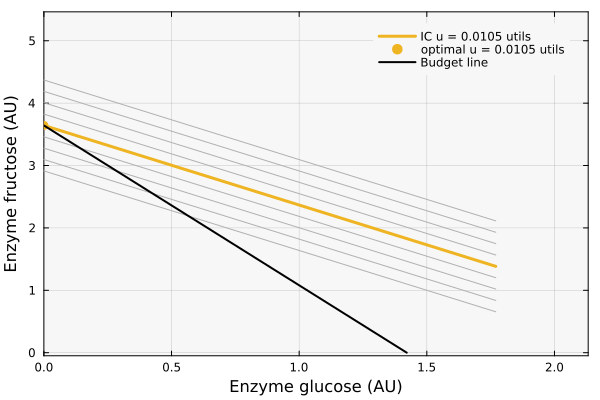

In [20]:
q = plot();
model = build(VLLinearUtilityFunction, (
    α = γ[idx_test_sugars],
));
θ_array = range(0.80,stop=1.2,length=9) |> collect;
for i ∈ eachindex(θ_array)
    θᵢ = θ_array[i];
    indiff_array = indifference(model,  utility = θᵢ*obj_value, 
        bounds = 1.25*bounds_enzyme_values[idx_test_sugars[1],:] , ϵ=0.01)

    line_color = :gray69
    lwv = 1
    labeltext = ""
    if (θᵢ == 1.0)
        line_color = :goldenrod2
        lwv = 3
        labeltext="IC u = $(round(θᵢ*obj_value,digits=4)) utils"
    end
    
    plot!(indiff_array[:,1],indiff_array[:,2], xlims=(0.0,1.5*(1/b̂[idx_test_sugars[1]])), 
        ylims=(-0.05,1.5*(1/b̂[idx_test_sugars[2]])), lw=lwv, c=line_color, label=labeltext, 
        bg=:gray97, background_color_outside="white", framestyle = :box, fg_legend = :transparent)
end
current()
scatter!([test_soln[1]],[test_soln[2]], c=:goldenrod2, msc=:goldenrod2, ms=5, label="optimal u = $(round(obj_value,digits=4)) utils")
plot!(budget_line[:,1],budget_line[:,2],c=:black, lw=2, label="Budget line")
xlabel!("Enzyme $(my_test_sugars[1]) (AU)", fontsize=18)
ylabel!("Enzyme $(my_test_sugars[2]) (AU)", fontsize=18)

In [21]:
savefig(joinpath(_PATH_TO_FIGS, "Fig-$(my_test_sugars[1])-$(my_test_sugars[2])-IC-Budget-GB-lambda.pdf"))

"/Users/jeffreyvarner/Desktop/julia_work/CHEME-4800-5800-Labs-AY-2024/week-10/Lab-10d/figs/Fig-glucose-fructose-IC-Budget-GB-lambda.pdf"